In [1]:
from utils.loader import DataLoader
from models.gpt import GPT2
import numpy as np
import pandas as pd

In [2]:
SPECIAL_TOKENS  = { "bos_token": "<|BOS|>",
                    "eos_token": "<|EOS|>",
                    "unk_token": "<|UNK|>",                    
                    "pad_token": "<|PAD|>",
                    "sep_token": "<|SEP|>"}

In [3]:
def sample_start_amazon(df, length=5):
    sample = df.sample(n=1)
    title, category, text = list(sample['REVIEW_TITLE'])[0], list(sample['PRODUCT_CATEGORY'])[0], list(sample['REVIEW_TEXT'])[0]
    sample = str(text).split(' ')
    return ' '.join(sample[:length]), title, category, text

def sample_start_gold(df, length=5):
    sample = df.sample(n=1)
    text = list(sample['REVIEW_TEXT'])[0]
    sample = str(text).split(' ')
    return ' '.join(sample[:length]), text

In [8]:
# Load our test-data that we will be sampling categories and prompts from
data_loader = DataLoader()
data_amazon = data_loader.load_amazon(test_mode=True, deceptive=False)

In [59]:
# Load our model
model_path = 'training/distilgpt-topic-full/pytorch_model.bin'
model = GPT2(model_path=model_path, full_model=False, special_tokens=SPECIAL_TOKENS)

In [10]:
# These are the available categories
categories = ['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Electronics', 'Furniture', 'Grocery', 'Health & Personal Care', 'Home', 'Home Entertainment', 'Home Improvement', 'Jewelry', 'Kitchen', 'Lawn and Garden', 'Luggage', 'Musical Instruments', 'Office Products', 'Outdoors', 'PC', 'Pet Products', 'Shoes', 'Sports', 'Tools', 'Toys', 'Video DVD', 'Video Games', 'Watches', 'Wireless']
start_words = ['A', 'After', 'All', 'Any', 'Apart', 'Arrived', 'As', 'At', 'Attended', 'Avoid', 'Awesome', 'Be', 'Beautiful', 'Before', 'Booked', 'Check', "Didn't", 'Despite', 'Do', "Don't", 'Elegant', 'Even', 'Excellent', 'First', 'Firstly', 'For', 'From', 'Generally', 'Going', 'Good', 'Got', 'Great', 'Guys', 'Had', 'Have', 'Having', 'Here', 'How', 'I', "I'd", "I'll", "I'm", "I've", 'If', 'In', 'It', "It's", 'Just', 'Let', 'Me', 'My', 'Nice', 'No', 'Not', 'Often', 'Ok,', 'On', 'Other', 'Our', 'Overall', 'Recently', 'Rude,', 'Seriously', 'Simply', 'Sometimes', 'The', 'They', 'This', 'Used', 'Very', 'Was', 'We', "We've", 'Well', 'Went', 'What', "What's", 'When', 'While']

In [7]:
# Begin generating samples
# 25k will be sampled with random category and random start word from OPSpam as it has better grammar
# 25k sampled from Amazon dataset with corresponding category and first 2-5 words and let GPT finish

In [ ]:
# Here we sample a random category, and a random start word.
all_reviews = []
while len(all_reviews) < 5000:
    print(f'{len(all_reviews)}/5000')
    prompt = np.random.choice(start_words)
    cat = np.random.choice(categories)
    prompt = SPECIAL_TOKENS['bos_token'] + cat + SPECIAL_TOKENS['sep_token'] + prompt
    outputs = model.generate_text(prompt, cat, print_output=False, do_sample=True, max_length=200, num_beams=5, repetition_penalty=5.0, num_return_sequences=3)
    for review in outputs:
        if len(review) > 10: # Ensure text generated is text
            all_reviews.append([cat, review])

In [ ]:
# Here we sample a random review and use its category and a random length start of sentence prompt.
all_reviews_second = []
while len(all_reviews_second) < 5000:
    print(f'{len(all_reviews_second)}/5000')
    # Sample a random prompt and corresponding category from the dataset and gemerate
    prompt, title, cat, original = sample_start_amazon(data_amazon, length=np.random.randint(4, 8))
    prompt = SPECIAL_TOKENS['bos_token'] + cat + SPECIAL_TOKENS['sep_token'] + prompt
    outputs = model.generate_text(prompt, cat, print_output=False, do_sample=True, max_length=70, num_beams=5, repetition_penalty=5.0, num_return_sequences=3)
    for review in outputs:
        if len(review) > 10: # Ensure text generated is text
            all_reviews_second.append([cat, review])

In [24]:
fake_reviews = pd.DataFrame(all_reviews, columns=['PRODUCT_CATEGORY', 'REVIEW_TEXT'])
fake_reviews = fake_reviews.drop_duplicates('REVIEW_TEXT')
fake_reviews = fake_reviews.reset_index()

In [98]:
fake_reviews_second = pd.DataFrame(all_reviews_second, columns=['PRODUCT_CATEGORY', 'REVIEW_TEXT'])
fake_reviews_second = fake_reviews_second.drop_duplicates('REVIEW_TEXT')
fake_reviews_second = fake_reviews_second.reset_index()

In [101]:
fake_reviews['SAMPLE_TYPE'] = 'NON-GUIDED'
fake_reviews_second['SAMPLE_TYPE'] = 'GUIDED'

In [111]:
final_data = pd.concat([fake_reviews, fake_reviews_second])
final_data = final_data.drop('index', axis=1)

# Final clean of line breaks
for i in range(len(final_data)):
    final_data.iloc[i]['REVIEW_TEXT'] = final_data.iloc[i]['REVIEW_TEXT'].replace('<br /><br />', ' ')

In [115]:
final_data['REVIEW_TEXT'] = final_data['REVIEW_TEXT'].astype(str)

In [116]:
final_data.to_csv('gpt_generated_data.csv', index=False)

### Analysis

In [1]:
import matplotlib.pyplot as plt

### Truthful data comparison

In [ ]:
# Guided vs non-guided
num_chars_g = [len(review) for review in fake_reviews_second['REVIEW_TEXT']]
num_chars_ng = [len(review) for review in fake_reviews['REVIEW_TEXT']]
num_words_g = [len(review.split(' ')) for review in fake_reviews_second['REVIEW_TEXT']]
num_words_ng = [len(review.split(' ')) for review in fake_reviews['REVIEW_TEXT']]
avg_words_g = [np.mean([len(w) for w in review.split(' ')]) for review in fake_reviews_second['REVIEW_TEXT']]
avg_words_ng = [np.mean([len(w) for w in review.split(' ')]) for review in fake_reviews['REVIEW_TEXT']]

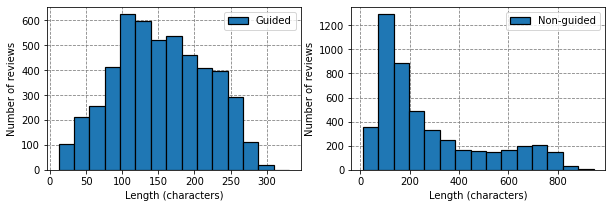

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([num_chars_g], bins=15, edgecolor='black', linewidth=1.2, label='Guided')
ax[0].set_xlabel('Length (characters)')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([num_chars_ng], bins=15, edgecolor='black', linewidth=1.2, label='Non-guided')
ax[1].set_xlabel('Length (characters)')
ax[1].set_ylabel('Number of reviews')
ax[1].legend()

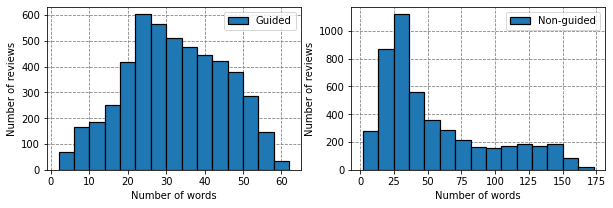

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([num_words_g], bins=15, edgecolor='black', linewidth=1.2, label='Guided')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([num_words_ng], bins=15, edgecolor='black', linewidth=1.2, label='Non-guided')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of reviews')
ax[1].legend()

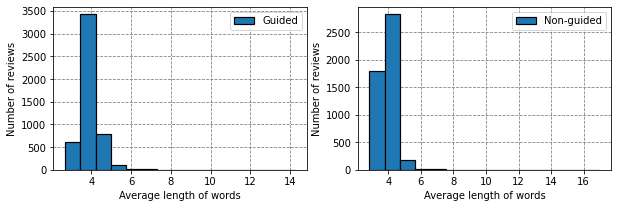

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([avg_words_g], bins=15, edgecolor='black', linewidth=1.2, label='Guided')
ax[0].set_xlabel('Average length of words')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([avg_words_ng], bins=15, edgecolor='black', linewidth=1.2, label='Non-guided')
ax[1].set_xlabel('Average length of words')
ax[1].set_ylabel('Number of reviews')
ax[1].legend()

In [30]:
# GPT vs Amazon
data_amazon_dec = data_loader.load_amazon(test_mode=True, deceptive=True)
num_chars_gpt = [len(review) for review in final_data['REVIEW_TEXT']]
num_chars_a = [len(review) for review in data_amazon['REVIEW_TEXT']]
num_words_gpt = [len(review.split(' ')) for review in final_data['REVIEW_TEXT']]
num_words_a = [len(review.split(' ')) for review in data_amazon['REVIEW_TEXT']]
avg_words_gpt = [np.mean([len(w) for w in review.split(' ')]) for review in final_data['REVIEW_TEXT']]
avg_words_a = [np.mean([len(w) for w in review.split(' ')]) for review in data_amazon['REVIEW_TEXT']]
num_chars_a_dec = [len(review) for review in data_amazon_dec['REVIEW_TEXT']]
num_words_a_dec = [len(review.split(' ')) for review in data_amazon_dec['REVIEW_TEXT']]
avg_words_a_dec = [np.mean([len(w) for w in review.split(' ')]) for review in data_amazon_dec['REVIEW_TEXT']]

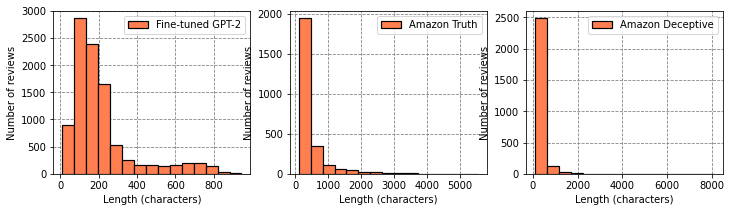

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(12 ,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([num_chars_gpt], bins=15, edgecolor='black', linewidth=1.2, label='Fine-tuned GPT-2', color='coral')
ax[0].set_xlabel('Length (characters)')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([num_chars_a], bins=15, edgecolor='black', linewidth=1.2, label='Amazon Truth', color='coral')
ax[1].set_xlabel('Length (characters)')
ax[1].set_ylabel('Number of reviews')
ax[1].legend()
ax[2].set_axisbelow(True)
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].hist([num_chars_a_dec], bins=15, edgecolor='black', linewidth=1.2, label='Amazon Deceptive', color='coral')
ax[2].set_xlabel('Length (characters)')
ax[2].set_ylabel('Number of reviews')
ax[2].legend()

(-5.0, 1000.0)

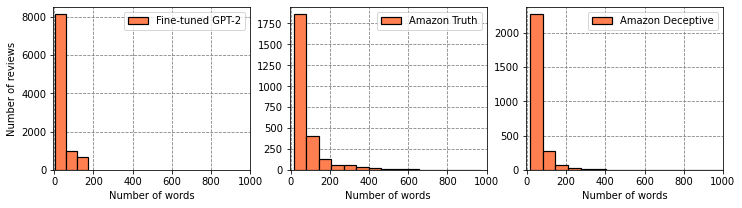

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([num_words_gpt], bins=3, edgecolor='black', linewidth=1.2, label='Fine-tuned GPT-2', color='coral')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([num_words_a], bins=15, edgecolor='black', linewidth=1.2, label='Amazon Truth', color='coral')
ax[1].set_xlabel('Number of words')
# ax[1].set_ylabel('Number of reviews')
ax[1].legend()
ax[2].set_axisbelow(True)
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].hist([num_words_a_dec], bins=18, edgecolor='black', linewidth=1.2, label='Amazon Deceptive', color='coral')
ax[2].set_xlabel('Number of words')
# ax[2].set_ylabel('Number of reviews')
ax[2].legend()
ax[0].set_xlim([-5, 1000])
ax[1].set_xlim([-5, 1000])
ax[2].set_xlim([-5, 1000])

(0.0, 14.0)

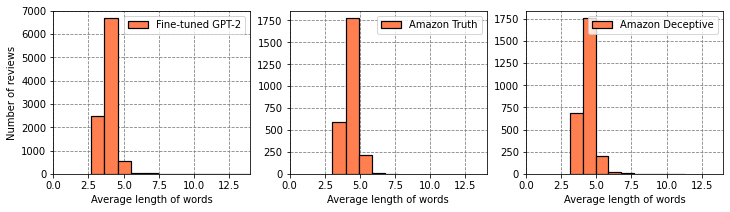

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].hist([avg_words_gpt], bins=15, edgecolor='black', linewidth=1.2, label='Fine-tuned GPT-2', color='coral')
ax[0].set_xlabel('Average length of words')
ax[0].set_ylabel('Number of reviews')
ax[0].legend()
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].hist([avg_words_a], bins=5, edgecolor='black', linewidth=1.2, label='Amazon Truth', color='coral')
ax[1].set_xlabel('Average length of words')
# ax[1].set_ylabel('Number of reviews')
ax[1].legend()
ax[2].set_axisbelow(True)
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].hist([avg_words_a_dec], bins=9, edgecolor='black', linewidth=1.2, label='Amazon Deceptive', color='coral')
ax[2].set_xlabel('Average length of words')
# ax[2].set_ylabel('Number of reviews')
ax[2].legend()
ax[0].set_xlim([0,14])
ax[1].set_xlim([0,14])
ax[2].set_xlim([0,14])

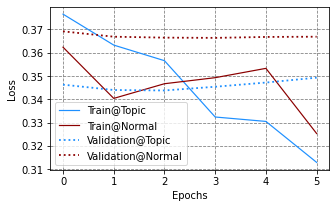

In [22]:
train = [0.3624, 0.3404, 0.3467,0.3493,0.3533,0.3253]#25
val = [0.3692,0.3669,0.3665,0.3664,0.3668,0.3669]
train2 = [0.37, 0.3233, 0.3049,0.2816,0.2624,0.2266]#24
val2 = [0.376, 0.378, 0.3827, 0.3923,0.4074,0.4183]
train3 = [0.3745,0.3574,0.3679,0.3746, 0.3817, 0.3534]#25
val3 = [0.3798,0.3759,0.3741,0.3731,0.3727, 0.3725]
train4 = [0.3766, 0.3633,0.3566,0.3324,0.3305,0.3129]#topic25
val4 = [0.3463, 0.3440,0.3438,0.3454,0.3472,0.3493]
fig, ax = plt.subplots(figsize=(5,3))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.plot(list(range(6)), train4, linewidth=1.2, label='Train@Topic', color='dodgerblue')
ax.plot(list(range(6)), train, linewidth=1.2, label='Train@Normal',color='darkred')
#ax.plot(list(range(6)), train3, linewidth=1.2, label='Train@2e-6', color='darkorange')
ax.plot(list(range(6)), val4,  linewidth=1.8, label='Validation@Topic', linestyle='dotted',color='dodgerblue')
ax.plot(list(range(6)), val,  linewidth=1.8, label='Validation@Normal', linestyle='dotted',color='darkred')
#ax.plot(list(range(6)), val3,  linewidth=1.8, label='Validation@2e-6', linestyle='dotted', color='darkorange')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc='lower left')

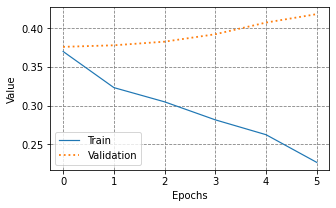

In [7]:
train = [0.37, 0.3233, 0.3049,0.2816,0.2624,0.2266]
val = [0.376, 0.378, 0.3827, 0.3923,0.4074,0.4183]
fig, ax = plt.subplots(figsize=(5,3))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.plot(list(range(6)), train, linewidth=1.2, label='Train')
ax.plot(list(range(6)), val,  linewidth=1.8, label='Validation', linestyle='dotted')
ax.set_xlabel('Epochs')
ax.set_ylabel('Value')
ax.legend()